In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier as xgb
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'gender_submission.csv']


In [2]:
os.getcwd()
train = pd.read_csv('../input/train.csv')
validate = pd.read_csv('../input/test.csv')

In [3]:
sub_format = pd.read_csv('../input/gender_submission.csv')

In [4]:
sub_format.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Lets do pivot analysis and see how are the people in different categories are stacked against the odds to survive.

In [6]:
for col in ['Pclass','Sex','SibSp','Parch','Cabin','Embarked']:
    print('{} : {}'.format(col,train[col].unique()))

Pclass : [3 1 2]
Sex : ['male' 'female']
SibSp : [1 0 3 4 2 5 8]
Parch : [0 1 2 5 3 4 6]
Cabin : [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B6

In [7]:
train[['Survived','Pclass','Sex','Embarked']].groupby(['Sex','Pclass','Embarked']).mean()

Survived
Sex    Pclass Embarked          
female 1      C         0.976744
              Q         1.000000
              S         0.958333
       2      C         1.000000
              Q         1.000000
              S         0.910448
       3      C         0.652174
              Q         0.727273
              S         0.375000
male   1      C         0.404762
              Q         0.000000
              S         0.354430
       2      C         0.200000
              Q         0.000000
              S         0.154639
       3      C         0.232558
              Q         0.076923
              S         0.128302

With the above we can discern that 
1. The Females had high probability of surviving than men in general.
2. Females in Pclass 1 and 2 had way higher survival rate.
3. Female in Class 1/2 v/s Men in Class 1/2 --- Female were more probable to survive



In [8]:
train[['Survived','Pclass']].groupby('Pclass').mean().sort_values(by = 'Survived', ascending = False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


***Pclass 1 people were in general more probable to survive

In [9]:
train[['Survived','Sex']].groupby('Sex').mean().sort_values(by='Survived',ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


**Females were more probable to survive

In [10]:
train[['Survived','Embarked']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


It looks like the people who embarked from 'C' were more probable for surviving

In [11]:
train[['Survived','SibSp','Parch']].groupby(['SibSp','Parch']).mean().sort_values(by = 'Survived',ascending=False)

Survived
SibSp Parch          
3     0      1.000000
0     3      1.000000
2     3      1.000000
      1      0.857143
0     2      0.724138
      1      0.657895
1     2      0.631579
      1      0.596491
      0      0.520325
2     2      0.500000
1     5      0.333333
      3      0.333333
4     2      0.333333
0     0      0.303538
3     2      0.285714
2     0      0.250000
4     1      0.000000
5     2      0.000000
1     6      0.000000
3     1      0.000000
1     4      0.000000
0     5      0.000000
      4      0.000000
8     2      0.000000


It looks like the people having sibling and spouse 2/3 and Parent/child 0/3 had better surviving prospects. but we may have to see that later 

Lets do some feature engineering now


In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
train.Pclass.unique() ###Pclass looks ok

array([3, 1, 2])

In [14]:
train.Sex.unique()###Sex looks ok

array(['male', 'female'], dtype=object)

In [15]:
###From the name, lets get the title
train['Title'] = train['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0]

In [16]:
train['Title'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer'], dtype=object)

There are quite a few titles which we can tie back to the Title, lets do that

Lets convert as below 
Capt, Col, Don, Jonkheer, Major, Rev, Sir = Mr (Since there likelyhood of being Mr is very high)
Lady,Mlle, Mme = Mrs
the Countess, Ms = Miss



In [17]:
pd.crosstab(train['Title'],train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40
Miss,182,0


In [18]:
train['Title'] = train['Title'].str.strip()

In [19]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [20]:
train['Title'] = train['Title'].replace(['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir'],'Mr')
train['Title'] = train['Title'].replace(['Lady','Mlle', 'Mme'],'Mrs')
train['Title'] = train['Title'].replace(['the Countess', 'Ms'],'Miss')

In [21]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Dr'], dtype=object)

In [22]:
pd.crosstab(train['Title'],train['Sex'])

Sex,female,male
Title,,
Dr,1,6
Master,0,40
Miss,184,0
Mr,0,531
Mrs,129,0


In [23]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [24]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Lets create bins for Age

In [25]:
lkp = pd.DataFrame(columns = ['Mean'])
for row_index, row in train[train['Age'].isnull()][['Pclass','Title','Embarked']].iterrows():
    lkp.loc[row_index] = train[(train['Pclass'] == row['Pclass'])  & (train['Title'] == row['Title']) & (train['Embarked'] == row['Embarked'])]['Age'].mean(skipna=True)
    ##print(row_index,row['Pclass'],row['Title'],row['Embarked'])
    ##print(train.ix[row_index]['Age'],

In [26]:
for ind,mean_age in lkp.iterrows():
    train.loc[ind,'Age'] = mean_age[0]

In [27]:
train[train['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


Lets do binning now Age feature

In [28]:
bins = [0,2,10,20,40,80]
labels = ['Infant','Child','Teenager','Adult','Senior']
train['Age'] = pd.cut(train['Age'],bins= bins,labels=labels )

In [29]:
train['Age'].unique()

[Adult, Senior, Infant, Teenager, Child]
Categories (5, object): [Infant < Child < Teenager < Adult < Senior]

Age looks good now, lets Sibsp an PArch

In [30]:
##lets find out the family size from these two variables 
train['Family_size'] = train['SibSp'] + train['Parch']

In [31]:
train.loc[: , ['Family_size','SibSp','Parch']].head(10)

,Family_size,SibSp,Parch
0,1,1,0
1,1,1,0
2,0,0,0
3,1,1,0
4,0,0,0
5,0,0,0
6,0,0,0
7,4,3,1
8,2,0,2
9,1,1,0


Lets look at ticket now 
There are numeric as well as Alphanumeric numbers .. Lets try to get the first alphbet and see if it is useful

In [32]:
lst = list(range(10))
num = ''.join(str(e) for e in lst)
train.loc[:,'Ticket'] = train.loc[:,'Ticket'].apply(lambda x : np.nan if x[0] in num else x[0] )

Lets replace the nan with 'O'

In [33]:
train.loc[:,'Ticket'].fillna('O',inplace=True)

In [34]:
train.loc[:,'Ticket'].unique()

array(['A', 'P', 'S', 'O', 'C', 'W', 'F', 'L'], dtype=object)

In [35]:
train.iloc[:,9].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [36]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,Adult,1,0,A,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,Adult,1,0,P,71.2833,C85,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,Adult,0,0,S,7.9250,NaN,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,Adult,1,0,O,53.1000,C123,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,Adult,0,0,O,8.0500,NaN,S,Mr,0


In [37]:
train.loc[:,'Fare'].unique()

array([  7.25  ,  71.2833,   7.925 ,  53.1   ,   8.05  ,   8.4583,
        51.8625,  21.075 ,  11.1333,  30.0708,  16.7   ,  26.55  ,
        31.275 ,   7.8542,  16.    ,  29.125 ,  13.    ,  18.    ,
         7.225 ,  26.    ,   8.0292,  35.5   ,  31.3875, 263.    ,
         7.8792,   7.8958,  27.7208, 146.5208,   7.75  ,  10.5   ,
        82.1708,  52.    ,   7.2292,  11.2417,   9.475 ,  21.    ,
        41.5792,  15.5   ,  21.6792,  17.8   ,  39.6875,   7.8   ,
        76.7292,  61.9792,  27.75  ,  46.9   ,  80.    ,  83.475 ,
        27.9   ,  15.2458,   8.1583,   8.6625,  73.5   ,  14.4542,
        56.4958,   7.65  ,  29.    ,  12.475 ,   9.    ,   9.5   ,
         7.7875,  47.1   ,  15.85  ,  34.375 ,  61.175 ,  20.575 ,
        34.6542,  63.3583,  23.    ,  77.2875,   8.6542,   7.775 ,
        24.15  ,   9.825 ,  14.4583, 247.5208,   7.1417,  22.3583,
         6.975 ,   7.05  ,  14.5   ,  15.0458,  26.2833,   9.2167,
        79.2   ,   6.75  ,  11.5   ,  36.75  ,   7.7958,  12.5

In [38]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

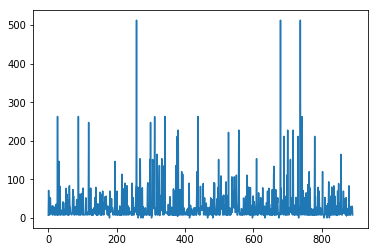

In [39]:
train['Fare'].plot()

In [40]:
train.loc[:,'Fare'] = pd.cut(train['Fare'],bins=[0,8,15,32,1000],labels=['Low','Medium','High','VeryHigh'])

In [41]:
train['Fare'].unique()

[Low, VeryHigh, Medium, High, NaN]
Categories (4, object): [Low < Medium < High < VeryHigh]

In [42]:
train.loc[(train['Fare'].isnull()) & (train.Pclass == 1),'Fare'] = 'VeryHigh'
train.loc[(train['Fare'].isnull()) & (train.Pclass == 2),'Fare'] = 'Medium'
train.loc[(train['Fare'].isnull()) & (train.Pclass == 3),'Fare'] = 'Low'

In [43]:
pd.crosstab(train.Pclass,train.Fare)

Fare,Low,Medium,High,VeryHigh
Pclass,,,,
1,1,0,51,164
2,0,95,67,22
3,229,128,104,30


In [44]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,Adult,1,0,A,Low,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,Adult,1,0,P,VeryHigh,C85,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,Adult,0,0,S,Low,NaN,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,Adult,1,0,O,VeryHigh,C123,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,Adult,0,0,O,Medium,NaN,S,Mr,0


lets look at cabin now 

In [45]:
train['Cabin'].unique()
train['Cabin'].value_counts(dropna=False)
train['Cabin'].isnull().sum()

687

lets take the first alphabet of cabin.. 

In [46]:
train.loc[train['Cabin'].notnull(),'Cabin'] = train.loc[train['Cabin'].notnull(),'Cabin'].apply(lambda x: str(x)[0]) 

In [47]:
train['Cabin'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [48]:
train['Cabin'].fillna('N',inplace=True)

In [49]:
train['Cabin'].unique()

array(['N', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [50]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,Adult,1,0,A,Low,N,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,Adult,1,0,P,VeryHigh,C,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,Adult,0,0,S,Low,N,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,Adult,1,0,O,VeryHigh,C,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,Adult,0,0,O,Medium,N,S,Mr,0


Lets drop the redundent columns now ..

In [51]:
train.drop(['PassengerId','Name','SibSp','Parch'],axis=1,inplace=True)

In [52]:
train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Family_size
0,0,3,male,Adult,A,Low,N,S,Mr,1
1,1,1,female,Adult,P,VeryHigh,C,C,Mrs,1
2,1,3,female,Adult,S,Low,N,S,Miss,0
3,1,1,female,Adult,O,VeryHigh,C,S,Mrs,1
4,0,3,male,Adult,O,Medium,N,S,Mr,0


In [53]:
train['Embarked'].isnull().sum()
train['Embarked'].unique()
train.loc[train['Embarked'].isnull(),'Embarked'] = train['Embarked'].mode()[0]

In [54]:
train['Embarked'].isnull().sum()

0

In [55]:
train['Embarked'].mode()

0    S
dtype: object

Now lets do some data visualization to see some trends

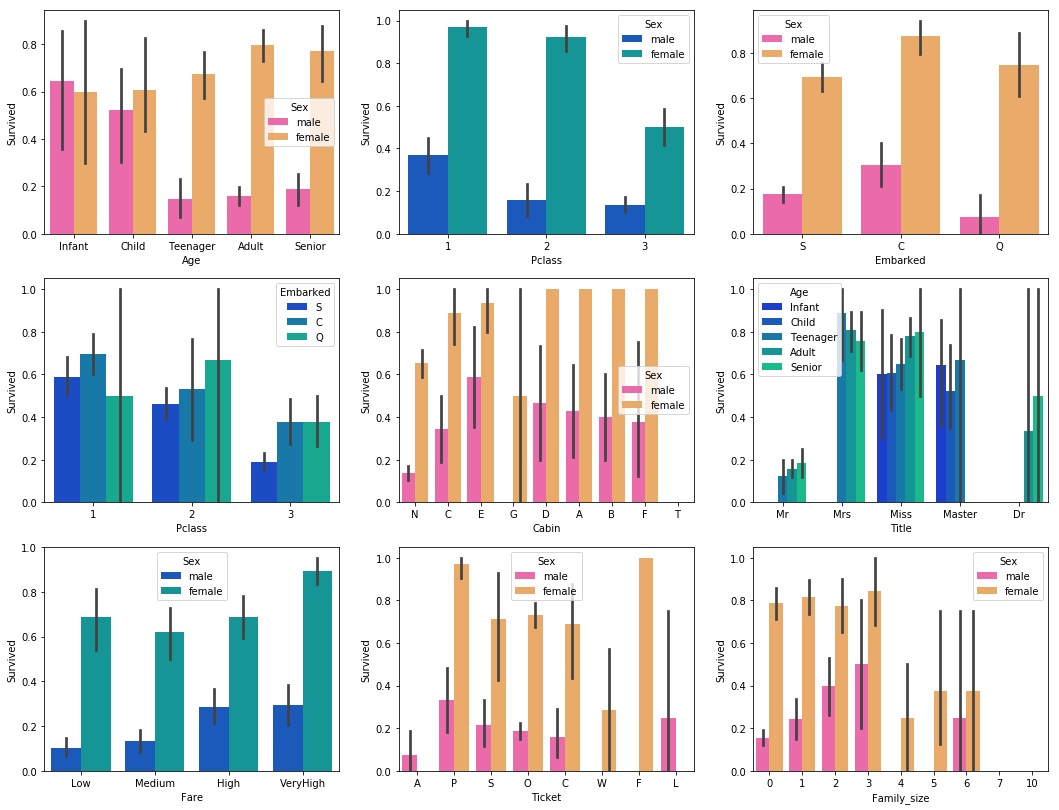

In [56]:
_,axis = plt.subplots(3,3,figsize=(18,14))
sns.barplot(x='Age',y = 'Survived',hue='Sex',data=train , palette='spring',ax=axis[0,0])
sns.barplot(x='Pclass',y = 'Survived',hue='Sex',data=train , palette='winter',ax=axis[0,1])
sns.barplot(x='Embarked',y = 'Survived',hue='Sex',data=train , palette='spring',ax=axis[0,2])
sns.barplot(x='Pclass',y = 'Survived',hue='Embarked',data=train , palette='winter',ax=axis[1,0])
sns.barplot(x='Cabin',y = 'Survived',hue='Sex',data=train , palette='spring',ax=axis[1,1])
sns.barplot(x='Title',y = 'Survived',hue='Age',data=train , palette='winter',ax=axis[1,2])
sns.barplot(x='Fare',y = 'Survived',hue='Sex',data=train , palette='winter',ax=axis[2,0])
sns.barplot(x='Ticket',y = 'Survived',hue='Sex',data=train , palette='spring',ax=axis[2,1])
sns.barplot(x='Family_size',y = 'Survived',hue='Sex',data=train , palette='spring',ax=axis[2,2])

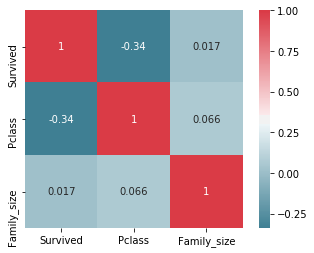

In [57]:
cmap = sns.diverging_palette(220,10,as_cmap=True)
_,ax = plt.subplots(figsize=(6,4))
sns.heatmap(train.corr(),annot=True,cmap = cmap,square=True, ax=ax)

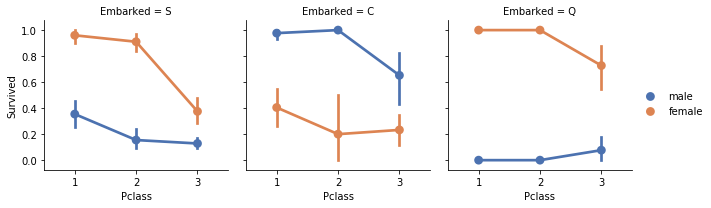

In [58]:

grid = sns.FacetGrid(train,col='Embarked')
grid.map(sns.pointplot,'Pclass','Survived','Sex',palette='deep')
grid.add_legend()

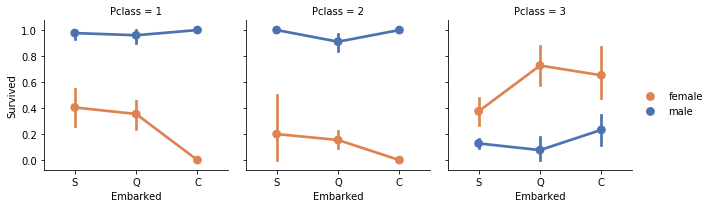

In [59]:
grid = sns.FacetGrid(train,col='Pclass')
grid.map(sns.pointplot,'Embarked','Survived','Sex',palette='deep')
grid.add_legend()

Lets split the train into train and test

In [60]:
train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Family_size
0,0,3,male,Adult,A,Low,N,S,Mr,1
1,1,1,female,Adult,P,VeryHigh,C,C,Mrs,1
2,1,3,female,Adult,S,Low,N,S,Miss,0
3,1,1,female,Adult,O,VeryHigh,C,S,Mrs,1
4,0,3,male,Adult,O,Medium,N,S,Mr,0


Lets create dummies now

Fare and Pclass are highly correlated so we will drop Fare

##pd.get_dummies(train,columns=)

In [61]:
train.drop('Fare',axis=1,inplace=True)

In [62]:
train.head()

,Survived,Pclass,Sex,Age,Ticket,Cabin,Embarked,Title,Family_size
0,0,3,male,Adult,A,N,S,Mr,1
1,1,1,female,Adult,P,C,C,Mrs,1
2,1,3,female,Adult,S,N,S,Miss,0
3,1,1,female,Adult,O,C,S,Mrs,1
4,0,3,male,Adult,O,N,S,Mr,0


In [63]:
train[['Cabin','Survived']].groupby('Cabin').mean()

,Survived
Cabin,
A,0.466667
B,0.744681
C,0.593220
D,0.757576
E,0.750000
F,0.615385
G,0.500000
N,0.299854
T,0.000000


In [64]:

Dummy_col = ['Sex','Age','Cabin','Embarked','Title']

In [65]:
pd.get_dummies(train['Age'],prefix='Age',drop_first=True).head()

,Age_Child,Age_Teenager,Age_Adult,Age_Senior
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [66]:
for col in Dummy_col:
    train = pd.concat((train,pd.get_dummies(train[col],prefix=col,drop_first=True)),axis=1)

In [67]:
train.drop(Dummy_col,axis=1,inplace=True)

In [68]:
train.drop('Ticket',axis=1,inplace=True)

In [69]:
train.head()

,Survived,Pclass,Family_size,Sex_male,Age_Child,Age_Teenager,Age_Adult,Age_Senior,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,0,3,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,1,3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
3,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
4,0,3,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0


In [70]:
X = train.drop('Survived',axis=1)
y = train['Survived']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [72]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((668, 21), (223, 21), (668,), (223,))

In [73]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

In [74]:
accuracy = accuracy_score(y_test,y_pred)
f1score = f1_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

In [75]:
accuracy, f1score,precision,recall

(0.7533632286995515,
 0.6783625730994152,
 0.7631578947368421,
 0.6105263157894737)

In [76]:
param_list = { "n_estimators" : [10,20,30,40,50,60,70],
              "criterion": ['gini','entropy'],
              "max_depth" : [4,5,6,7,8,9,None],
              "min_samples_split" : [2,3,4,5,6]
                
}

In [77]:
rfc_cv = RandomForestClassifier()

In [78]:
rfc_cv_best_model = RandomizedSearchCV(rfc_cv,param_list,cv =5)

In [79]:
rfc_cv_best_model.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [10, 20, 30, 40, 50, 60, 70], 'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8, 9, None], 'min_samples_split': [2, 3, 4, 5, 6]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [80]:
print(rfc_cv_best_model.best_params_)
print(rfc_cv_best_model.best_score_)

{'n_estimators': 70, 'min_samples_split': 5, 'max_depth': 8, 'criterion': 'entropy'}
0.8383233532934131


###final RandomForestClassifier Hyper parameters are as above


Lets check the Decision tree classifier now 

In [81]:
dtc = DecisionTreeClassifier()

In [82]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [83]:
dtc_y_pred = dtc.predict(X_test)

In [84]:
accuracy = accuracy_score(y_test,dtc_y_pred)
f1score = f1_score(y_test,dtc_y_pred)
precision = precision_score(y_test,dtc_y_pred)
recall = recall_score(y_test,dtc_y_pred)

In [85]:
accuracy, f1score,precision,recall

(0.7354260089686099, 0.6467065868263473, 0.75, 0.5684210526315789)

In [86]:
dtc_param_list = {"criterion": ['gini','entropy'],
                  "max_depth" : [3,4,5,6,7,8,9,None],
                  "min_samples_split" : [2,3,4,5,6]
}

In [87]:
dtc_cv = DecisionTreeClassifier()

In [88]:
dtc_cv_best_model = RandomizedSearchCV(dtc_cv,dtc_param_list,cv =5)

In [89]:
dtc_cv_best_model.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, None], 'min_samples_split': [2, 3, 4, 5, 6]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [90]:
print(dtc_cv_best_model.best_params_)
print(dtc_cv_best_model.best_score_)

{'min_samples_split': 3, 'max_depth': 3, 'criterion': 'entropy'}
0.8383233532934131


In [91]:
log_reg = LogisticRegression()

In [92]:
log_reg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [93]:
log_y_pred = log_reg.predict(X_test)

In [94]:
accuracy = accuracy_score(y_test,log_y_pred)
f1score = f1_score(y_test,log_y_pred)
precision = precision_score(y_test,log_y_pred)
recall = recall_score(y_test,log_y_pred)

In [95]:
accuracy, f1score,precision,recall

(0.8116591928251121,
 0.7613636363636362,
 0.8271604938271605,
 0.7052631578947368)

In [96]:
log_param_list = {"penalty" : ['l1', 'l2'],
    "C" : np.logspace(-4, 4, 20),
    "solver" : ['liblinear','warn']}

In [97]:
log_reg_cv = LogisticRegression()

In [98]:
log_reg_cv_best_model = RandomizedSearchCV(log_reg_cv,log_param_list, cv=10)

In [99]:
log_reg_cv_best_model.fit(X_train,y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'penalty': ['l1', 'l2'], 'C': array([1.00000e-04, 2.63665e-04, 6.95193e-04, 1.83298e-03, 4.83293e-03,
       1.27427e-02, 3.35982e-02, 8.85867e-02, 2.33572e-01, 6.15848e-01,
       1.62378e+00, 4.28133e+00, 1.12884e+01, 2.97635e+01, 7.84760e+01,
       2.06914e+02, 5.45559e+02, 1.43845e+03, 3.79269e+03, 1.00000e+04]), 'solver': ['liblinear', 'warn']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [100]:
print(log_reg_cv_best_model.best_params_)
print(log_reg_cv_best_model.best_score_)

{'solver': 'warn', 'penalty': 'l2', 'C': 1.623776739188721}
0.8308383233532934


Best results received from logistic regression is 82.6%

Lets look at XGBoost now 

In [101]:
xgb_clf = xgb()

In [102]:
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [103]:
xbg_y_pred = xgb_clf.predict(X_test)

In [104]:
accuracy = accuracy_score(y_test, xbg_y_pred)

In [105]:
accuracy

0.7982062780269058

In [106]:
xbg_param_list = {"n_estimators" : [30,40,50,60,80,90,100,130],
                  "max_depth"    : [3,4,5,6,7,8,9,10]
                  
}

In [107]:
xgb_clf_cv = xgb()

In [108]:
xgb_cv_best_model = RandomizedSearchCV(xgb_clf_cv,xbg_param_list,cv=10)

In [109]:
xgb_cv_best_model.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [30, 40, 50, 60, 80, 90, 100, 130], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [110]:
print(xgb_cv_best_model.best_params_)
print(xgb_cv_best_model.best_score_)

{'n_estimators': 40, 'max_depth': 5}
0.8398203592814372


In [111]:
knn = KNeighborsClassifier()

In [112]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [113]:
knn_y_pred = knn.predict(X_test)

In [114]:
accuracy = accuracy_score(y_test, knn_y_pred)

In [115]:
accuracy

0.757847533632287

In [116]:
knn_cv = KNeighborsClassifier()

In [117]:
knn_param_list = { "n_neighbors" : list(range(5,30)),
                  "weights" : ['uniform','distance'],
                  "algorithm" : ['auto', 'ball_tree', 'kd_tree'],
                  "p" : [1,2]
}

In [118]:
knn_cv_best_model = RandomizedSearchCV(knn_cv,knn_param_list,cv=10)

In [119]:
knn_cv_best_model.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree'], 'p': [1, 2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [120]:
print(knn_cv_best_model.best_params_)
print(knn_cv_best_model.best_score_)

{'weights': 'uniform', 'p': 2, 'n_neighbors': 25, 'algorithm': 'ball_tree'}
0.8353293413173652


In [121]:
nbc = GaussianNB()

In [122]:
nbc.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [123]:
nbc_y_pred = nbc.predict(X_test)

In [124]:
accuracy = accuracy_score(y_test,nbc_y_pred)

In [125]:
accuracy

0.7354260089686099

In [126]:
nbc_cv = GaussianNB()

consilidating all the parameters

In [127]:
Output_lst = {'Random Forest' : [rfc_cv_best_model.best_params_,rfc_cv_best_model.best_score_] ,
              'Decision Tree' : [dtc_cv_best_model.best_params_,dtc_cv_best_model.best_score_] ,
              'Log Reg' : [log_reg_cv_best_model.best_params_, log_reg_cv_best_model.best_score_],
              'XGBoost' : [xgb_cv_best_model.best_params_, xgb_cv_best_model.best_score_],
              'KN Neighbor' : [knn_cv_best_model.best_params_, knn_cv_best_model.best_score_],
             }


In [128]:
Output_lst

{'Random Forest': [{'n_estimators': 70,
   'min_samples_split': 5,
   'max_depth': 8,
   'criterion': 'entropy'},
  0.8383233532934131],
 'Decision Tree': [{'min_samples_split': 3,
   'max_depth': 3,
   'criterion': 'entropy'},
  0.8383233532934131],
 'Log Reg': [{'solver': 'warn', 'penalty': 'l2', 'C': 1.623776739188721},
  0.8308383233532934],
 'XGBoost': [{'n_estimators': 40, 'max_depth': 5}, 0.8398203592814372],
 'KN Neighbor': [{'weights': 'uniform',
   'p': 2,
   'n_neighbors': 25,
   'algorithm': 'ball_tree'},
  0.8353293413173652]}

Lets do cross validation on all the best parameterized models 

In [129]:
final_models = {'rfc_final' : RandomForestClassifier(n_estimators= 70,min_samples_split= 6,max_depth= 6,criterion= 'entropy') ,
              'dtc_final' : DecisionTreeClassifier(min_samples_split= 3,max_depth= 3,criterion= 'gini') ,
              'Log Reg' : LogisticRegression(solver= 'liblinear',penalty= 'l1',C= 0.08858667904100823),
              'XGBoost' : xgb(n_estimators= 40, max_depth= 8),
              'KN Neighbor' : KNeighborsClassifier(weights= 'uniform',p= 2,n_neighbors= 27,algorithm = 'auto')
             }


we will use stratified kfold cross validation for perfect results 

In [130]:
skfold = StratifiedKFold(n_splits=10,random_state = 0)

In [131]:
result = {}

for name,model in final_models.items():
    cv_result = cross_val_score(model,X_train,y_train,cv=skfold,scoring='accuracy')
    result[name] = cv_result.mean()
    

In [132]:
print(result)

{'rfc_final': 0.8429337270864927, 'dtc_final': 0.8339538936334371, 'Log Reg': 0.8354690451485887, 'XGBoost': 0.8309255859738739, 'KN Neighbor': 0.8370074759890388}


Random forest is the best model among all... but we will use Voting Classifier to further increase our prediction power. We will use soft an hard both to arrive at the best one.

In [133]:
estimators = []
for clf,model in final_models.items():
    if clf in ['rfc_final','KN Neighbor']:
        estimators.append((clf,model))
    else:
        continue

In [134]:
estimators

[('rfc_final',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
              max_depth=6, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=6,
              min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)),
 ('KN Neighbor',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=27, p=2,
             weights='uniform'))]

In [135]:
voting_clf = VotingClassifier(estimators = estimators,voting='hard' )

In [136]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('rfc_final', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
           ...i',
           metric_params=None, n_jobs=None, n_neighbors=27, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [137]:
voting_y_pred = voting_clf.predict(X_test)

In [138]:
accuracy = accuracy_score(y_test,voting_y_pred)

In [139]:
accuracy

0.7892376681614349

I tried multiple voting classifier combinations but nothing works better than Random Forest alone. so we will stick to Random Forest alone.

In [140]:
validate.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Now we will transform our validate dataset as what we have done in train_test

In [141]:
validate['Title'] = validate['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0]

validate['Title'] = validate['Title'].replace(['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir'],'Mr')
validate['Title'] = validate['Title'].replace(['Lady','Mlle', 'Mme'],'Mrs')
validate['Title'] = validate['Title'].replace(['the Countess', 'Ms'],'Miss')

lkp = pd.DataFrame(columns = ['Mean'])
for row_index, row in validate[validate['Age'].isnull()][['Pclass','Title','Embarked']].iterrows():
    lkp.loc[row_index] = validate[(validate['Pclass'] == row['Pclass'])  & (validate['Title'] == row['Title']) & (validate['Embarked'] == row['Embarked'])]['Age'].mean(skipna=True)
    ##print(row_index,row['Pclass'],row['Title'],row['Embarked'])
    ##print(validate.ix[row_index]['Age'],

for ind,mean_age in lkp.iterrows():
    validate.loc[ind,'Age'] = mean_age[0]

bins = [0,2,10,20,40,80]
labels = ['Infant','Child','Teenager','Adult','Senior']
validate['Age'] = pd.cut(validate['Age'],bins= bins,labels=labels )

In [142]:
##lets find out the family size from these two variables 
validate['Family_size'] = validate['SibSp'] + validate['Parch']

lst = list(range(10))
num = ''.join(str(e) for e in lst)
validate.loc[:,'Ticket'] = validate.loc[:,'Ticket'].apply(lambda x : np.nan if x[0] in num else x[0] )

validate.loc[:,'Ticket'].fillna('O',inplace=True)

validate.loc[:,'Fare'] = pd.cut(validate['Fare'],bins=[0,8,15,32,1000],labels=['Low','Medium','High','VeryHigh'])

validate.loc[(validate['Fare'].isnull()) & (validate.Pclass == 1),'Fare'] = 'VeryHigh'
validate.loc[(validate['Fare'].isnull()) & (validate.Pclass == 2),'Fare'] = 'Medium'
validate.loc[(validate['Fare'].isnull()) & (validate.Pclass == 3),'Fare'] = 'Low'

In [143]:
validate.loc[validate['Cabin'].notnull(),'Cabin'] = validate.loc[validate['Cabin'].notnull(),'Cabin'].apply(lambda x: str(x)[0]) 

validate['Cabin'].fillna('N',inplace=True)

validate.drop(['PassengerId','Name','SibSp','Parch'],axis=1,inplace=True)

validate.loc[validate['Embarked'].isnull(),'Embarked'] = validate['Embarked'].mode()[0]

validate.drop('Fare',axis=1,inplace=True)

In [144]:
Dummy_col = ['Sex','Age','Cabin','Embarked','Title']

pd.get_dummies(validate['Age'],prefix='Age',drop_first=True).head()

for col in Dummy_col:
    validate = pd.concat((validate,pd.get_dummies(validate[col],prefix=col,drop_first=True)),axis=1)

validate.drop(Dummy_col,axis=1,inplace=True)

validate.drop('Ticket',axis=1,inplace=True)


In [145]:
validate.head()

,Pclass,Family_size,Sex_male,Age_Child,Age_Teenager,Age_Adult,Age_Senior,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Embarked_Q,Embarked_S,Title_ Dona,Title_ Dr,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_ Ms,Title_ Rev
0,3,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
1,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
2,2,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
3,3,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
4,3,2,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0


In [146]:
X_test.head()

,Pclass,Family_size,Sex_male,Age_Child,Age_Teenager,Age_Adult,Age_Senior,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs
862,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1
223,3,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
84,2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
680,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
535,2,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0


In [147]:
validate.head()

,Pclass,Family_size,Sex_male,Age_Child,Age_Teenager,Age_Adult,Age_Senior,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Embarked_Q,Embarked_S,Title_ Dona,Title_ Dr,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_ Ms,Title_ Rev
0,3,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
1,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
2,2,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
3,3,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
4,3,2,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0


In [148]:
validate['Cabin_T'] = 0

In [149]:
validate.drop('Title_ Dona',axis=1,inplace = True)

In [150]:
validate.drop(['Title_ Ms','Title_ Dr','Title_ Rev'],axis=1,inplace = True)

In [151]:
y_validate =  rfc_cv_best_model.predict(validate)

In [152]:
y_validate

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [153]:
submission = pd.read_csv('../input/test.csv')

In [154]:
submission.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [155]:
submission.drop([ 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'], axis = 1, inplace =True)

In [156]:
submission.head()

,PassengerId
0,892
1,893
2,894
3,895
4,896


In [157]:
y_validate = pd.Series(y_validate)

In [158]:
submission = pd.concat([submission,y_validate], axis=1)

In [159]:
submission.head(20)

,PassengerId,0
0,892,0
1,893,0
2,894,1
3,895,0
4,896,0
5,897,1
6,898,1
7,899,1
8,900,0
9,901,0


In [160]:
os.getcwd()
os.listdir()

['__output__.json', '__notebook__.ipynb']

In [161]:
submission.to_csv('submission.csv', index=False)

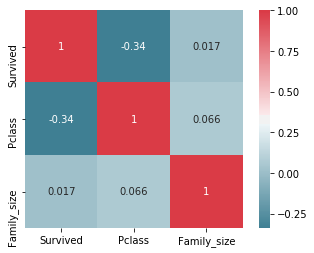

In [162]:
_